# ML Zoomcamp Mid-Term Project - Low Birth Weight Risk

## Data Preparation

In [1]:
#Import Libraries
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from IPython.display import display
from tqdm.auto import tqdm

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import xgboost as xgb
import pickle

In [2]:
#Import data
births_df = pd.read_stata("datasets/nac2020.dta")

#Adjust variable names
births_df.columns = births_df.columns.str.lower().str.replace(' ', '_')

print("All variables:", births_df.columns)

All variables: Index(['cod_dpto', 'cod_munic', 'areanac', 'sit_parto', 'otro_sit', 'sexo',
       'peso_nac', 'talla_nac', 'ano', 'mes', 'aten_par', 't_ges', 'numconsul',
       'tipo_parto', 'mul_parto', 'apgar1', 'apgar2', 'idhemoclas',
       'idfactorrh', 'idpertet', 'edad_madre', 'est_civm', 'niv_edum',
       'ultcurmad', 'codpres', 'codptore', 'codmunre', 'area_res', 'n_hijosv',
       'fecha_nacm', 'n_emb', 'seg_social', 'idclasadmi', 'edad_padre',
       'niv_edup', 'ultcurpad', 'profesion'],
      dtype='object')


In [3]:
#Variables of interest following recommendations in articles reviewed and availability before birth
birth_vars = ["mul_parto", "t_ges", "numconsul"]
mom_vars = ["edad_madre", "est_civm", "niv_edum", "n_hijosv", "n_emb", "seg_social", "area_res"]
dad_vars = ["edad_padre", "niv_edup"]
selected_vars = birth_vars + mom_vars + dad_vars + ["peso_nac"]

#Filter dataset
births_df = births_df[selected_vars]
births_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629402 entries, 0 to 629401
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   mul_parto   629402 non-null  object 
 1   t_ges       629402 non-null  float64
 2   numconsul   629402 non-null  float64
 3   edad_madre  629402 non-null  float64
 4   est_civm    629402 non-null  object 
 5   niv_edum    629402 non-null  object 
 6   n_hijosv    629402 non-null  float64
 7   n_emb       629402 non-null  float64
 8   seg_social  629402 non-null  object 
 9   area_res    629402 non-null  object 
 10  edad_padre  629402 non-null  float64
 11  niv_edup    629402 non-null  object 
 12  peso_nac    629402 non-null  float64
dtypes: float64(7), object(6)
memory usage: 67.2+ MB


### Inclusion Criteria

In [4]:
#Only newborns for which all information is available

no_area_res = births_df[births_df["area_res"]==""].index
births_df.drop(labels = no_area_res, axis=0, inplace=True)

#Explore missing values
missing_val_vars = {"peso_nac":9.0, "mul_parto":"9", "edad_madre":99.0, "est_civm":"9",
                   "niv_edum":"99", "n_hijosv":99.0, "n_emb":99.0, "edad_padre":999.0, 
                   "area_res":"9", "niv_edup":"99"}

missing_val_count = 0
missing_val_df = births_df.copy()
for key in missing_val_vars.keys():
    count = missing_val_df[missing_val_df[key]==missing_val_vars[key]][key].count()
    missing_val_count = missing_val_count + count
    missing_val_df = missing_val_df[missing_val_df[key]!=missing_val_vars[key]]
    print(f"{key}:", count)

print("")

#Missing info in low weight newborn records
lw_births_df = births_df[births_df["peso_nac"]<=4]
missing_val_count_low = 0
for key in missing_val_vars.keys():    
    count = lw_births_df[lw_births_df[key]==missing_val_vars[key]][key].count()
    missing_val_count_low = missing_val_count_low + count
    lw_birth_df = lw_births_df[lw_births_df[key]!=missing_val_vars[key]]
    print(f"{key}:", count)

print("")

print("Missing values in all records:", missing_val_count)
print("Missing values in low weight newborn records:", missing_val_count_low)

peso_nac: 8417
mul_parto: 12
edad_madre: 53
est_civm: 14116
niv_edum: 10244
n_hijosv: 6
n_emb: 5
edad_padre: 3895
area_res: 7
niv_edup: 35684

peso_nac: 0
mul_parto: 1
edad_madre: 1
est_civm: 1290
niv_edum: 1908
n_hijosv: 1
n_emb: 2
edad_padre: 572
area_res: 1
niv_edup: 6029

Missing values in all records: 72439
Missing values in low weight newborn records: 9805


In [5]:
#Dropping missing info
for key in missing_val_vars.keys():
    index_drop = births_df[births_df[key]==missing_val_vars[key]].index.to_list()
    births_df.drop(labels=index_drop, axis=0, inplace=True)

births_df.reset_index(inplace=True, drop=True)
births_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547174 entries, 0 to 547173
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   mul_parto   547174 non-null  object 
 1   t_ges       547174 non-null  float64
 2   numconsul   547174 non-null  float64
 3   edad_madre  547174 non-null  float64
 4   est_civm    547174 non-null  object 
 5   niv_edum    547174 non-null  object 
 6   n_hijosv    547174 non-null  float64
 7   n_emb       547174 non-null  float64
 8   seg_social  547174 non-null  object 
 9   area_res    547174 non-null  object 
 10  edad_padre  547174 non-null  float64
 11  niv_edup    547174 non-null  object 
 12  peso_nac    547174 non-null  float64
dtypes: float64(7), object(6)
memory usage: 54.3+ MB


In [6]:
#Only single pregnancies
births_df = births_df[births_df["mul_parto"]=="1"]
births_df.drop("mul_parto", axis=1, inplace=True)

In [7]:
#Final variables list
births_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537582 entries, 0 to 547173
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   t_ges       537582 non-null  float64
 1   numconsul   537582 non-null  float64
 2   edad_madre  537582 non-null  float64
 3   est_civm    537582 non-null  object 
 4   niv_edum    537582 non-null  object 
 5   n_hijosv    537582 non-null  float64
 6   n_emb       537582 non-null  float64
 7   seg_social  537582 non-null  object 
 8   area_res    537582 non-null  object 
 9   edad_padre  537582 non-null  float64
 10  niv_edup    537582 non-null  object 
 11  peso_nac    537582 non-null  float64
dtypes: float64(7), object(5)
memory usage: 53.3+ MB


In [8]:
#Classify final variable list in numeric and categorical

#Numeric variables
numeric_vars = ["t_ges", "numconsul", "edad_madre", "n_hijosv", "n_emb", "edad_padre"]

#Categorical variables
categorical_vars = ["est_civm", "niv_edum","seg_social", "area_res", "niv_edup"]

In [9]:
#Dictionary for variable names in English
var_names = {"edad_madre":"Age - mother","est_civm":"Marital status - mother", 
             "niv_edum":"Education level - mother","n_hijosv":"Living children - mother",
             "n_emb":"Previous pregnancies - mother", 
             "seg_social":"Health Insurance Regime - mother",
             "edad_padre":"Age - father", "niv_edup":"Education level - father", 
             "area_res":"Residential area - mother", "peso_nac":"Birth weight",
             "numconsul":"Pre-natal medical visits", "t_ges":"Gestation Time"}

In [10]:
#Category Label Dictionaries
est_civm_labels = {"1":"Cohabiting - 2Y or more", "2":"Cohabiting - less than 2Y", "3":"Divorced", 
                  "4":"Widowed", "5":"Single", "6":"Married"}
niv_edu_labels = {"01":"Preschool", "02":"Primary", "03":"Secondary", "04":"Secondary", 
                  "05":"Secondary", "06":"Non-University Higher", "07":"Non-University Higher", 
                  "08":"Non-University Higher", "09":"Undegraduate","10":"Postgraduate", 
                  "11":"Postgraduate", "12":"Postgraduate", "13":"None"}
seg_social_labels = {"1":"Contributory", "2":"Subsidized", "3":"Exception", "4":"Special", 
                     "5":"Non-insured"}
area_res_labels = {"1":"Cabecera Municipal", "2":"Centro Poblado", "3":"Rural"}

In [11]:
#Apply Category Label Dictionaries
births_df["est_civm"] = births_df["est_civm"].map(est_civm_labels)
births_df["niv_edum"] = births_df["niv_edum"].map(niv_edu_labels)
births_df["niv_edup"] = births_df["niv_edup"].map(niv_edu_labels)
births_df["seg_social"] = births_df["seg_social"].map(seg_social_labels)
births_df["area_res"] = births_df["area_res"].map(area_res_labels)

In [12]:
#Declare categorical variables as such
for var in categorical_vars:
    births_df[var] = births_df[var].astype("category")

### Low Weight Identifier

In [13]:
def lbw_identifier(w):
    if w<=4:
        return 1
    else:
        return 0
    
births_df["lbw"] = births_df["peso_nac"].apply(lbw_identifier)

In [14]:
births_df["lbw"].value_counts()

0    494601
1     42981
Name: lbw, dtype: int64

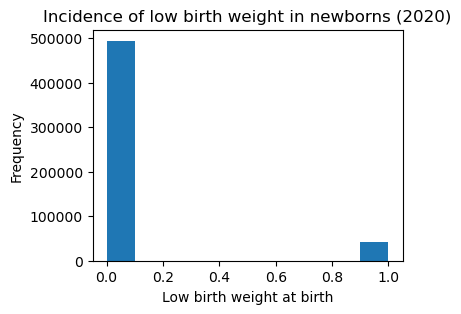

In [15]:
#Verify whether that the data is imbalanced
plt.figure(figsize=(4, 3))

plt.hist(births_df["lbw"])
plt.ylabel('Frequency')
plt.xlabel('Low birth weight at birth')
plt.title('Incidence of low birth weight in newborns (2020)')

plt.show()

### Train and Test Sets

In [16]:
#Divide in train, validation and test sets
#Stratified sampling will be using to account for imbalanced nature of the data
df_train_full, df_test = train_test_split(births_df, test_size=0.2, random_state=1, 
                                          stratify=births_df.lbw)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11, 
                                    stratify=df_train_full.lbw)

#Reset index
df_train.reset_index(drop=True, inplace=True) 
df_val.reset_index(drop=True, inplace=True) 
df_test.reset_index(drop=True, inplace=True) 

In [17]:
#Calculate y_train, y_val and y_test variable for all sets
y_train = df_train.lbw.values
y_val = df_val.lbw.values
y_test = df_test.lbw.values

df_train.drop("peso_nac", axis=1, inplace=True)
df_val.drop("peso_nac", axis=1, inplace=True)
df_test.drop("peso_nac", axis=1, inplace=True)
df_train.drop("lbw", axis=1, inplace=True)
df_val.drop("lbw", axis=1, inplace=True)
df_test.drop("lbw", axis=1, inplace=True)

## Exploratory Data Analysis

### Dependant variable

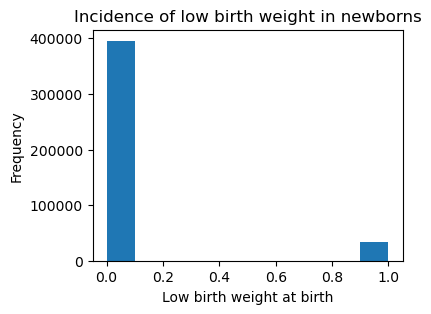

In [18]:
plt.figure(figsize=(4, 3))

plt.hist(df_train_full["lbw"])
plt.ylabel('Frequency')
plt.xlabel('Low birth weight at birth')
plt.title('Incidence of low birth weight in newborns')

plt.show()

In [19]:
#Percentage of confirmed low birth weight new borns after dropping missing info
low_bw_rate = (df_train_full[df_train_full["peso_nac"]<=4]["peso_nac"].count())/df_train_full["peso_nac"].count()
low_bw_rate

0.07995303035587643

### Features

In [20]:
df_train_full.describe()

,t_ges,numconsul,edad_madre,n_hijosv,n_emb,edad_padre,peso_nac,lbw
count,430065.000000,430065.000000,430065.000000,430065.000000,430065.000000,430065.000000,430065.000000,430065.000000
mean,3.799628,5.923951,3.781121,1.892616,2.077202,29.704603,5.767505,0.079953
std,0.418767,3.255292,1.312985,1.121044,1.276589,7.568099,1.019230,0.271221
min,1.000000,0.000000,1.000000,1.000000,1.000000,13.000000,1.000000,0.000000
25%,4.000000,4.000000,3.000000,1.000000,1.000000,24.000000,5.000000,0.000000
50%,4.000000,6.000000,4.000000,2.000000,2.000000,29.000000,6.000000,0.000000
75%,4.000000,8.000000,5.000000,2.000000,3.000000,34.000000,6.000000,0.000000
max,9.000000,99.000000,9.000000,17.000000,17.000000,84.000000,8.000000,1.000000


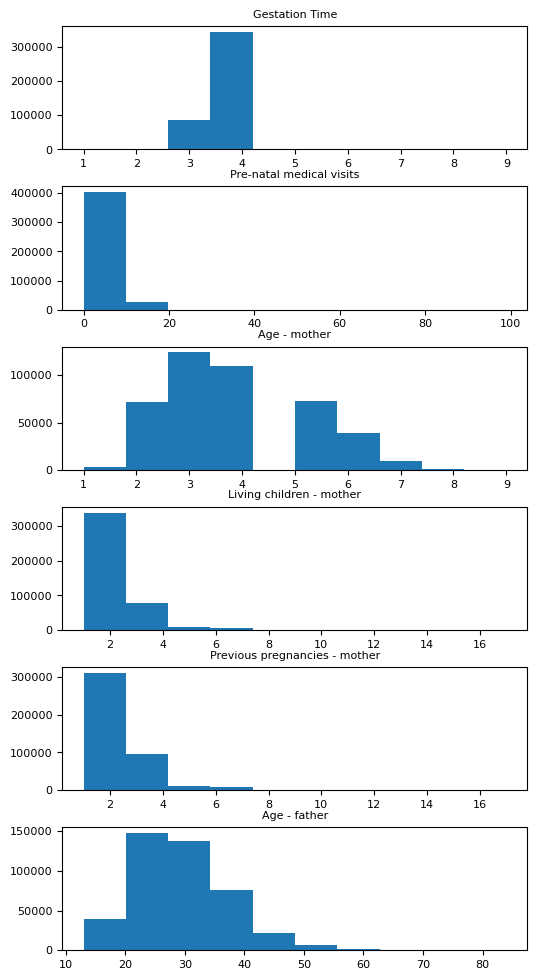

In [21]:
#Histograms for numeric variables
i=0
fig, axs = plt.subplots(nrows=len(numeric_vars), ncols=1)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.set_size_inches(6, 12)
for ax, var in zip(axs.flat,numeric_vars):
    ax.hist(df_train_full[var])
    ax.set_title(label=var_names[var], fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    i = i+1


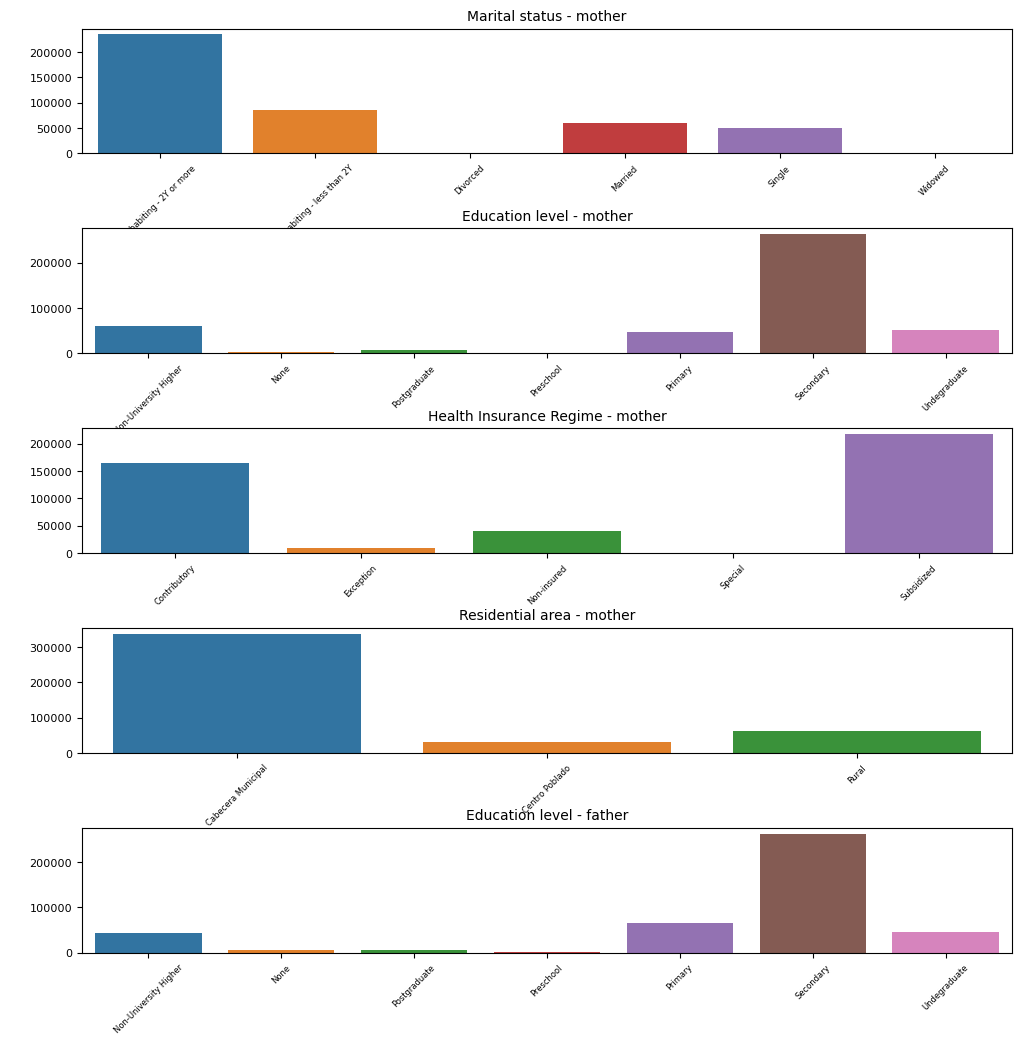

In [22]:
#Countplots for categorical variables
i=0
fig, axs = plt.subplots(nrows=len(categorical_vars), ncols=1)
fig.subplots_adjust(hspace=0.6, wspace=0.2)
fig.set_size_inches(12, 12)
for ax, var in zip(axs.flat,categorical_vars):
    sns.countplot(x=df_train_full[var], ax=ax)
    ax.set_title(label=var_names[var], fontsize=10)
    ax.set_xlabel(" ")
    ax.set_ylabel(" ")
    ax.tick_params(axis='x', rotation=45, labelsize=6)
    ax.tick_params(axis='y', labelsize=8)
    i = i+1


### Feature Importance

In [23]:
df_train_full.lbw.value_counts(normalize=True)

0    0.920047
1    0.079953
Name: lbw, dtype: float64

In [24]:
#Mean comparison for categorical variables

#Mean birth weight
global_mean = df_train_full.lbw.mean()
print("Average low birth weight incidence:", global_mean)

#Mean comparison
for var in categorical_vars:
    df_group = df_train_full.groupby(by=var).lbw.agg(["mean"])
    df_group.index.name = var_names[var]
    df_group["diff"] = df_group["mean"] - global_mean
    df_group["risk"] = df_group["mean"] / global_mean
    display(df_group)   


Average low birth weight incidence: 0.07995303035587643


,mean,diff,risk
Marital status - mother,,,
Cohabiting - 2Y or more,0.076581,-0.003372,0.957820
Cohabiting - less than 2Y,0.084645,0.004692,1.058688
Divorced,0.090566,0.010613,1.132741
Married,0.075820,-0.004133,0.948312
Single,0.092682,0.012729,1.159205
Widowed,0.053968,-0.025985,0.674999


,mean,diff,risk
Education level - mother,,,
Non-University Higher,0.079685,-0.000268,0.996651
None,0.090700,0.010747,1.134416
Postgraduate,0.071833,-0.008120,0.898444
Preschool,0.077949,-0.002004,0.974931
Primary,0.077709,-0.002244,0.971932
Secondary,0.080977,0.001024,1.012813
Undegraduate,0.077478,-0.002475,0.969043


,mean,diff,risk
Health Insurance Regime - mother,,,
Contributory,0.085060,0.005107,1.063873
Exception,0.069595,-0.010358,0.870453
Non-insured,0.087831,0.007878,1.098536
Special,0.100000,0.020047,1.250734
Subsidized,0.075037,-0.004916,0.938512


,mean,diff,risk
Residential area - mother,,,
Cabecera Municipal,0.082092,0.002139,1.026755
Centro Poblado,0.066363,-0.013590,0.830022
Rural,0.074888,-0.005065,0.936645


,mean,diff,risk
Education level - father,,,
Non-University Higher,0.075916,-0.004037,0.949510
None,0.089448,0.009495,1.118753
Postgraduate,0.073415,-0.006538,0.918225
Preschool,0.076122,-0.003831,0.952081
Primary,0.077480,-0.002473,0.969065
Secondary,0.082143,0.002190,1.027387
Undegraduate,0.074232,-0.005721,0.928441


In [25]:
#Mutual information score for categorical variables

def calculate_mi(series):
    return mutual_info_score(series, df_train_full.peso_nac)

df_mi = df_train_full[categorical_vars].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi.rename(index=var_names, inplace=True)

display(df_mi)

,MI
Marital status - mother,0.001250
Health Insurance Regime - mother,0.000939
Education level - father,0.000522
Education level - mother,0.000391
Residential area - mother,0.000296


In [26]:
#Correlation for numerical variables
df_train_full[numeric_vars+["lbw"]].corr()

,t_ges,numconsul,edad_madre,n_hijosv,n_emb,edad_padre,lbw
t_ges,1.000000,0.082257,-0.016799,-0.004872,-0.020940,-0.005591,-0.456563
numconsul,0.082257,1.000000,0.162394,-0.128277,-0.098739,0.110503,-0.065051
edad_madre,-0.016799,0.162394,1.000000,0.430820,0.455945,0.634190,0.003396
n_hijosv,-0.004872,-0.128277,0.430820,1.000000,0.914847,0.337009,-0.024500
n_emb,-0.020940,-0.098739,0.455945,0.914847,1.000000,0.350538,-0.013066
edad_padre,-0.005591,0.110503,0.634190,0.337009,0.350538,1.000000,-0.007424
lbw,-0.456563,-0.065051,0.003396,-0.024500,-0.013066,-0.007424,1.000000


## Modelling

### Logistic Regression Model

In [27]:
#Fit model with all variables using statsmodel module to evaluate significance of variables

df_train_sm = df_train.copy()
y_train_sm = y_train.copy()

#Encoding for categorical variables
df_train_sm = pd.get_dummies(df_train_sm, drop_first=True)

df_train_sm["intercept"] = 1

logit = sm.Logit(y_train_sm, df_train_sm)
logit_res = logit.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.196099
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               288143
Model:                          Logit   Df Residuals:                   288113
Method:                           MLE   Df Model:                           29
Date:                Thu, 10 Nov 2022   Pseudo R-squ.:                  0.2963
Time:                        02:23:03   Log-Likelihood:                -56505.
converged:                       True   LL-Null:                       -80293.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
t_ges                                 -3.1570      0.018   -178.166      0.000      -3.192      -3.122
numconsul                             -0.0689      0.003    -20.176      0.000      -0.076      -0.062
edad_madre                             0.1197      0.009     13.616      0.000       0.102       0.137
n_hijosv                              -0.2337      0.017    -13.689      0.000      -0.267      -0.200
n_emb                                  0.0231      0.014      1.621      0.105      -0.005       0.051
edad_padre                            -0.0040      0.001     -2.894      0.004      -0.007      -0.001
est_civm_Cohabiting - less than 2Y     0.0806      0.021      3.856      0.000       0.040       0.122
est_civm_Divorced                      0.1034      0.142      0.728      0.467      -0.175       0.382
est_civm_Married                      -0.0219      0.026     -0.845      0.398      -0.073       0.029
est_civm_Single                        0.1648      0.025      6.589      0.000       0.116       0.214
est_civm_Widowed                      -0.3036      0.353     -0.860      0.390      -0.996       0.388
niv_edum_None                          0.1567      0.103      1.523      0.128      -0.045       0.358
niv_edum_Postgraduate                 -0.2135      0.083     -2.572      0.010      -0.376      -0.051
niv_edum_Preschool                     0.1282      0.171      0.748      0.454      -0.207       0.464
niv_edum_Primary                       0.1057      0.038      2.805      0.005       0.032       0.180
niv_edum_Secondary                     0.0734      0.027      2.757      0.006       0.021       0.126
niv_edum_Undegraduate                 -0.0373      0.034     -1.088      0.277      -0.104       0.030
seg_social_Exception                  -0.3004      0.060     -5.000      0.000      -0.418      -0.183
seg_social_Non-insured                -0.0701      0.031     -2.245      0.025      -0.131      -0.009
seg_social_Special                     0.0391      0.424      0.092      0.926      -0.791       0.869
seg_social_Subsidized                 -0.1686      0.020     -8.571      0.000      -0.207      -0.130
area_res_Centro Poblado               -0.1981      0.033     -5.932      0.000      -0.264      -0.133
area_res_Rural                        -0.0244      0.025     -0.993      0.321      -0.072       0.024
niv_edup_None                          0.2456      0.075      3.276      0.001       0.099       0.393
niv_edup_Postgraduate                  0.0620      0.090      0.692      0.489      -0.114       0.238
niv_edup_Preschool                     0.2659      0.150      1.775      0.076      -0.028       0.559
niv_edup_Primary                       0.1472      0.038      3.886      0.000       0.073       0.221
niv_edup_Secondary                     0.1263      0.030      4.152      0.000       0.067       0.186
niv_edup_Undegraduate                 -0.0151   

In [28]:
#Encoding with DictVectorizer
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [29]:
#Prepare feature matrix for model training
X_train = dv.transform(train_dict)
X_train.shape

(288143, 34)

In [30]:
#Train the model
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [31]:
#Model validation
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [32]:
#Accuracy
print("Accuracy:", accuracy_score(y_val, y_pred>0.5))

Accuracy: 0.9230915573343104


In [33]:
#Precision
print("Precision:", precision_score(y_val, y_pred>0.5))

Precision: 0.9635193133047211


In [34]:
#Recall
print("Recall:", recall_score(y_val, y_pred>0.5))

Recall: 0.0395699303780735


In [35]:
#AUC score
print("AUC score:", roc_auc_score(y_val, y_pred))

AUC score: 0.8546007967113212


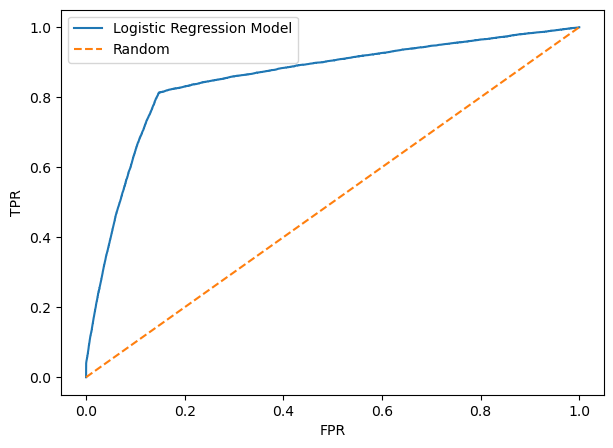

In [36]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(7, 5))

plt.plot(fpr, tpr, label='Logistic Regression Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [37]:
#Average Precision Score
print("Average Precision Score:", average_precision_score(y_val, y_pred))

Average Precision Score: 0.3983865872448247


#### Cross-validation

In [38]:
def train(df_train, y_train, C):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', random_state=1, C=C)
    model.fit(X_train, y_train)
    
    return dv, model

In [39]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [40]:
#Validation with StratifiedKFold to account for unbalanced data
n_splits = 3

df_train_full_cv = df_train_full[numeric_vars+categorical_vars]
y_train_full_cv = df_train_full["lbw"].values

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    
    scores1 = []
    scores2 = []
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_train_full_cv, y_train_full_cv):
        df_train_cv = df_train_full_cv.iloc[train_idx]
        df_val_cv = df_train_full_cv.iloc[val_idx]

        y_train_cv = y_train_full_cv[train_idx]
        y_val_cv = y_train_full_cv[val_idx]

        dv_cv, model_cv = train(df_train_cv, y_train_cv, C)
        y_pred_cv = predict(df_val_cv, dv_cv, model_cv)

        auc_roc = roc_auc_score(y_val_cv, y_pred_cv)
        aps = average_precision_score(y_val_cv, y_pred_cv)
        scores1.append(auc_roc)
        scores2.append(aps)

    print('C=%s, Mean ROC AUC: %.3f +- %.3f' % (C, np.mean(scores1), np.std(scores1)))
    print('C=%s, Mean Average Precision Score: %.3f +- %.3f' % (C, np.mean(scores2), 
                                                             np.std(scores2)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001, Mean ROC AUC: 0.842 +- 0.002
C=0.001, Mean Average Precision Score: 0.369 +- 0.007
C=0.01, Mean ROC AUC: 0.853 +- 0.002
C=0.01, Mean Average Precision Score: 0.392 +- 0.005
C=0.1, Mean ROC AUC: 0.855 +- 0.002
C=0.1, Mean Average Precision Score: 0.395 +- 0.004
C=0.5, Mean ROC AUC: 0.856 +- 0.002
C=0.5, Mean Average Precision Score: 0.395 +- 0.003
C=1, Mean ROC AUC: 0.856 +- 0.002
C=1, Mean Average Precision Score: 0.395 +- 0.003
C=5, Mean ROC AUC: 0.856 +- 0.002
C=5, Mean Average Precision Score: 0.395 +- 0.003
C=10, Mean ROC AUC: 0.856 +- 0.002
C=10, Mean Average Precision Score: 0.395 +- 0.003


#### SMOTE for class imbalance

In [41]:
#Oversampling the dataset using SMOTE
smt = SMOTE()
df_train_smt1, y_train_smt1 = smt.fit_resample(df_train_sm, y_train_sm)

<AxesSubplot:ylabel='Count'>

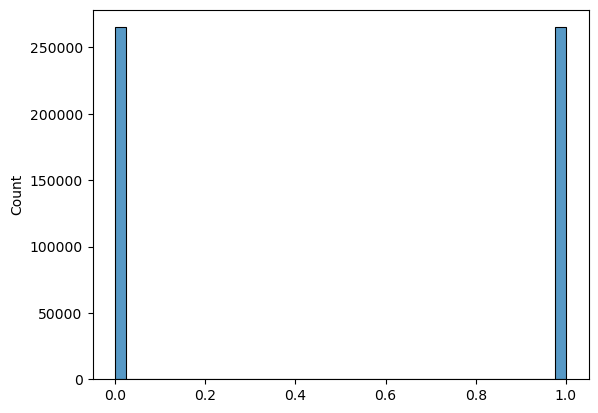

In [42]:
sns.histplot(x=y_train_smt1)

In [43]:
#Fit model with all variables using statsmodel module using oversampled data

#Encoding for categorical variables
df_train_smt1 = pd.get_dummies(df_train_smt1, drop_first=True)

df_train_smt1["intercept"] = 1

logit1 = sm.Logit(y_train_smt1, df_train_smt1)
logit1_res = logit1.fit()
logit1_res.summary()

Optimization terminated successfully.
         Current function value: 0.391840
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               530210
Model:                          Logit   Df Residuals:                   530180
Method:                           MLE   Df Model:                           29
Date:                Thu, 10 Nov 2022   Pseudo R-squ.:                  0.4347
Time:                        02:26:42   Log-Likelihood:            -2.0776e+05
converged:                       True   LL-Null:                   -3.6751e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
t_ges                                 -3.4925      0.008   -415.049      0.000      -3.509      -3.476
numconsul                             -0.0729      0.002    -42.717      0.000      -0.076      -0.070
edad_madre                             0.0283      0.005      6.014      0.000       0.019       0.037
n_hijosv                              -0.0490      0.010     -5.110      0.000      -0.068      -0.030
n_emb                                 -0.1267      0.008    -15.316      0.000      -0.143      -0.111
edad_padre                            -0.0070      0.001     -9.719      0.000      -0.008      -0.006
est_civm_Cohabiting - less than 2Y    -0.4385      0.011    -38.972      0.000      -0.461      -0.416
est_civm_Divorced                     -2.4207      0.143    -16.962      0.000      -2.700      -2.141
est_civm_Married                      -0.7107      0.014    -49.296      0.000      -0.739      -0.682
est_civm_Single                       -0.5709      0.014    -40.220      0.000      -0.599      -0.543
est_civm_Widowed                      -2.9647      0.369     -8.031      0.000      -3.688      -2.241
niv_edum_None                         -0.5973      0.073     -8.200      0.000      -0.740      -0.455
niv_edum_Postgraduate                 -0.7313      0.050    -14.708      0.000      -0.829      -0.634
niv_edum_Preschool                    -1.6914      0.165    -10.230      0.000      -2.015      -1.367
niv_edum_Primary                      -0.3347      0.019    -17.894      0.000      -0.371      -0.298
niv_edum_Secondary                    -0.2569      0.012    -21.607      0.000      -0.280      -0.234
niv_edum_Undegraduate                 -0.6127      0.018    -34.678      0.000      -0.647      -0.578
seg_social_Exception                  -1.8526      0.045    -41.594      0.000      -1.940      -1.765
seg_social_Non-insured                -0.5335      0.017    -31.650      0.000      -0.567      -0.500
seg_social_Special                    -2.3854      0.445     -5.361      0.000      -3.258      -1.513
seg_social_Subsidized                 -0.3024      0.010    -30.965      0.000      -0.322      -0.283
area_res_Centro Poblado               -1.3698      0.022    -62.659      0.000      -1.413      -1.327
area_res_Rural                        -0.6216      0.014    -44.399      0.000      -0.649      -0.594
niv_edup_None                         -1.2094      0.050    -24.004      0.000      -1.308      -1.111
niv_edup_Postgraduate                 -0.8746      0.055    -16.020      0.000      -0.982      -0.768
niv_edup_Preschool                    -1.8492      0.133    -13.924      0.000      -2.109      -1.589
niv_edup_Primary                      -0.4965      0.017    -28.693      0.000      -0.530      -0.463
niv_edup_Secondary                    -0.5353      0.013    -41.473      0.000      -0.561      -0.510
niv_edup_Undegraduate                 -0.7550   

In [44]:
#Oversampling the dataset using SMOTE for logistic regression with SKLearn
df_train1 = pd.get_dummies(df_train)

smt = SMOTE()
df_train_smt, y_train_smt = smt.fit_resample(df_train_sm, y_train)

In [45]:
#Encoding with DictVectorizer
train_dict_smt = df_train_smt.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [46]:
#Prepare feature matrix for model training
X_train_smt = dv.transform(train_dict_smt)
X_train_smt.shape

(530210, 34)

In [47]:
#Train the model
model_smt = LogisticRegression(solver='liblinear', random_state=1)
model_smt.fit(X_train_smt, y_train_smt)

LogisticRegression(random_state=1, solver='liblinear')

In [48]:
#Model validation
y_pred_smt = model_smt.predict_proba(X_val)[:, 1]

In [49]:
#Accuracy
print("Accuracy:", accuracy_score(y_val, y_pred_smt>0.5))

Accuracy: 0.8493256859401643


In [50]:
#Precision
print("Precision:", precision_score(y_val, y_pred_smt>0.5))

Precision: 0.3238813826987191


In [51]:
#Recall
print("Recall:", recall_score(y_val, y_pred_smt>0.5))

Recall: 0.8133427337622279


In [52]:
#AUC Score
print("AUC Score:", roc_auc_score(y_val, y_pred_smt))

AUC Score: 0.8532505500977038


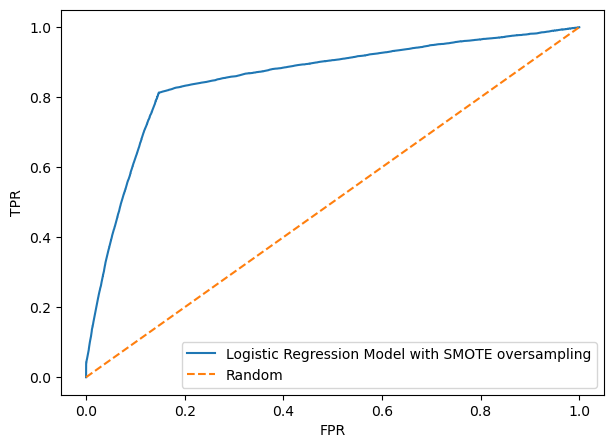

In [53]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_smt)

plt.figure(figsize=(7, 5))

plt.plot(fpr, tpr, label='Logistic Regression Model with SMOTE oversampling')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [54]:
#Average Precision Score
print("Average Precision Score:", average_precision_score(y_val, y_pred_smt))

Average Precision Score: 0.3885016963633938


In [55]:
#Validation with StratifiedKFold to account for unbalanced data
n_splits = 3

df_train_full_cv = df_train_full[numeric_vars+categorical_vars]
y_train_full_cv = df_train_full["lbw"].values

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    
    scores1 = []
    scores2 = []
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_train_full_cv, y_train_full_cv):
        df_train_cv = df_train_full_cv.iloc[train_idx]
        df_val_cv = df_train_full_cv.iloc[val_idx]

        df_train_cv = pd.get_dummies(df_train_cv)
        df_val_cv = pd.get_dummies(df_val_cv)        
              
        y_train_cv = y_train_full_cv[train_idx]
        y_val_cv = y_train_full_cv[val_idx]
        
        smt_cv = SMOTE()
        df_train_cv_smt, y_train_cv_smt = smt_cv.fit_resample(df_train_cv, y_train_cv)

        dv_cv_smt, model_cv_smt = train(df_train_cv_smt, y_train_cv_smt, C)
        y_pred_cv_smt = predict(df_val_cv, dv_cv_smt, model_cv_smt)

        auc_roc = roc_auc_score(y_val_cv, y_pred_cv_smt)
        aps = average_precision_score(y_val_cv, y_pred_cv_smt)
        scores1.append(auc_roc)
        scores2.append(aps)

    print('C=%s, Mean ROC AUC: %.3f +- %.3f' % (C, np.mean(scores1), np.std(scores1)))
    print('C=%s, Mean Average Precision Score: %.3f +- %.3f' % (C, np.mean(scores2), 
                                                             np.std(scores2)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001, Mean ROC AUC: 0.841 +- 0.002
C=0.001, Mean Average Precision Score: 0.360 +- 0.006
C=0.01, Mean ROC AUC: 0.848 +- 0.002
C=0.01, Mean Average Precision Score: 0.379 +- 0.005
C=0.1, Mean ROC AUC: 0.847 +- 0.002
C=0.1, Mean Average Precision Score: 0.379 +- 0.004
C=0.5, Mean ROC AUC: 0.847 +- 0.002
C=0.5, Mean Average Precision Score: 0.379 +- 0.003
C=1, Mean ROC AUC: 0.847 +- 0.002
C=1, Mean Average Precision Score: 0.379 +- 0.004
C=5, Mean ROC AUC: 0.847 +- 0.002
C=5, Mean Average Precision Score: 0.379 +- 0.003
C=10, Mean ROC AUC: 0.847 +- 0.002
C=10, Mean Average Precision Score: 0.379 +- 0.003


### Random Forest Model

In [56]:
#Random Forest Parameter Tuning

scores = []

for d in [1, 5, 10, 15]:
    for n in range(10, 101, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred_rf = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred_rf)

        scores.append((d, n, auc))

columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

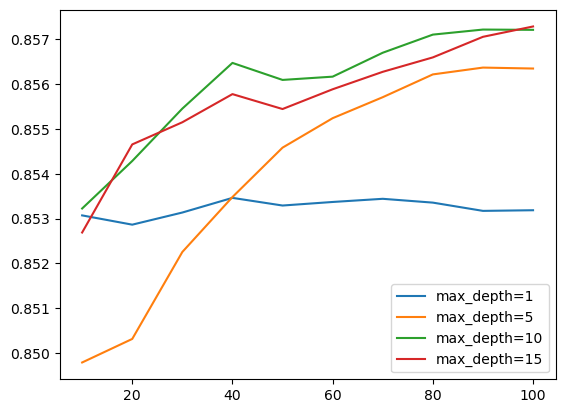

In [57]:
for d in [1, 5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [58]:
#Model with specified parameters 
rf = RandomForestClassifier(n_estimators=25, max_depth=10, random_state=1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_val)[:, 1]        

In [59]:
#Accuracy
print("Accuracy:", accuracy_score(y_val, y_pred_rf > 0.5))

Accuracy: 0.9218655317709727


In [60]:
#Precision
print("Precision:", precision_score(y_val, y_pred_rf > 0.5))

Precision: 0.9961538461538462


In [61]:
#Recall
print("Recall:", recall_score(y_val, y_pred_rf > 0.5))

Recall: 0.02282541640962369


In [62]:
#AUC Score
print("AUC Score:", roc_auc_score(y_val, y_pred_rf))

AUC Score: 0.8548299274411143


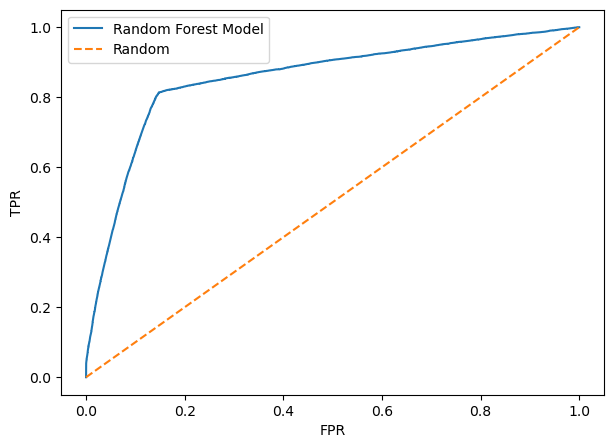

In [63]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rf)

plt.figure(figsize=(7, 5))

plt.plot(fpr, tpr, label='Random Forest Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [64]:
#Average Precision Score
print("Average Precision Score:", average_precision_score(y_val, y_pred_rf))

Average Precision Score: 0.4015503343904992


#### Cross-validation

In [65]:
def train_rf(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    rf = RandomForestClassifier(n_estimators=25, max_depth=10, random_state=1)
    rf.fit(X_train, y_train)

    return dv, rf

In [66]:
def predict_rf(df, dv, rf):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = rf.predict_proba(X)[:, 1]

    return y_pred

In [67]:
scores1 = []
scores2 = []
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_full_cv, y_train_full_cv):
    df_train_cv = df_train_full_cv.iloc[train_idx]
    df_val_cv = df_train_full_cv.iloc[val_idx]

    df_train_cv_rf = pd.get_dummies(df_train_cv)
    df_val_cv_rf = pd.get_dummies(df_val_cv)        
              
    y_train_cv_rf = y_train_full_cv[train_idx]
    y_val_cv_rf = y_train_full_cv[val_idx]        
    
    dv_cv_rf, model_cv_rf = train_rf(df_train_cv_rf, y_train_cv_rf)
    y_pred_cv_rf = predict_rf(df_val_cv_rf, dv_cv_rf, model_cv_rf)

    auc_roc = roc_auc_score(y_val_cv_rf, y_pred_cv_rf)
    aps = average_precision_score(y_val_cv_rf, y_pred_cv_rf)
    scores1.append(auc_roc)
    scores2.append(aps)

print('Mean ROC AUC: %.3f +- %.3f' % (np.mean(scores1), np.std(scores1)))
print('Mean Average Precision Score: %.3f +- %.3f' % (np.mean(scores2), 
                                                             np.std(scores2)))

Mean ROC AUC: 0.857 +- 0.003
Mean Average Precision Score: 0.402 +- 0.007


#### SMOTE for class imbalance

In [87]:
#Model with specified parameters
rf_smt = RandomForestClassifier(n_estimators=25, max_depth=10, random_state=1)
rf_smt.fit(X_train_smt, y_train_smt)

y_pred_rf_smt = rf_smt.predict_proba(X_val)[:, 1]

In [88]:
#Accuracy
print("Accuracy:", accuracy_score(y_val, y_pred_rf_smt > 0.5))

Accuracy: 0.8494807006665633


In [89]:
#Precision
print("Precision:", precision_score(y_val, y_pred_rf_smt > 0.5))

Precision: 0.32405748216858155


In [90]:
#Recall
print("Recall:", recall_score(y_val, y_pred_rf_smt > 0.5))

Recall: 0.8128139596369084


In [91]:
#AUC Score
print("AUC Score:", roc_auc_score(y_val, y_pred_rf_smt))

AUC Score: 0.8511108884966082


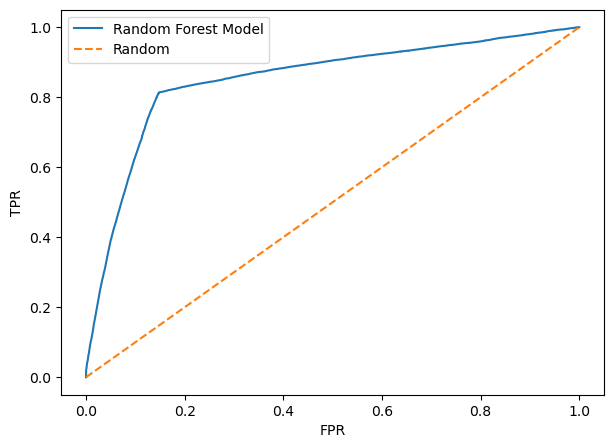

In [92]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rf_smt)

plt.figure(figsize=(7, 5))

plt.plot(fpr, tpr, label='Random Forest Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [93]:
#Average Precision Score
print("Average Precision Score:", average_precision_score(y_val, y_pred_rf_smt))

Average Precision Score: 0.3718757928700471


In [94]:
scores1 = []
scores2 = []
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_full_cv, y_train_full_cv):
    df_train_cv = df_train_full_cv.iloc[train_idx]
    df_val_cv = df_train_full_cv.iloc[val_idx]

    df_train_cv_rf = pd.get_dummies(df_train_cv)
    df_val_cv_rf = pd.get_dummies(df_val_cv)        
              
    y_train_cv_rf = y_train_full_cv[train_idx]
    y_val_cv_rf = y_train_full_cv[val_idx]
    
    smt_cv_rf = SMOTE()
    df_train_cv_rf_smt, y_train_cv_rf_smt = smt_cv_rf.fit_resample(df_train_cv_rf, y_train_cv_rf)
    
    dv_cv_rf_smt, model_cv_rf_smt = train_rf(df_train_cv_rf_smt, y_train_cv_rf_smt)
    y_pred_cv_rf_smt = predict_rf(df_val_cv_rf, dv_cv_rf_smt, model_cv_rf_smt)

    auc_roc = roc_auc_score(y_val_cv_rf, y_pred_cv_rf_smt)
    aps = average_precision_score(y_val_cv_rf, y_pred_cv_rf_smt)
    
    scores1.append(auc_roc)
    scores2.append(aps)

print('Mean ROC AUC: %.3f +- %.3f' % (np.mean(scores1), np.std(scores1)))
print('Mean Average Precision Score: %.3f +- %.3f' % (np.mean(scores2), 
                                                             np.std(scores2)))

Mean ROC AUC: 0.852 +- 0.002
Mean Average Precision Score: 0.348 +- 0.003


### XGBoost

In [96]:
#Divide in train, validation and test sets
#Stratified sampling will be using to account for imbalanced nature of the data
df_train_full, df_test = train_test_split(births_df, test_size=0.2, random_state=1, 
                                          stratify=births_df.lbw)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11, 
                                    stratify=df_train_full.lbw)

#Reset index
df_train.reset_index(drop=True, inplace=True) 
df_val.reset_index(drop=True, inplace=True) 
df_test.reset_index(drop=True, inplace=True)

#Calculate y_train, y_val and y_test variable for all sets
y_train = df_train.lbw.values
y_val = df_val.lbw.values
y_test = df_test.lbw.values

df_train.drop("peso_nac", axis=1, inplace=True)
df_val.drop("peso_nac", axis=1, inplace=True)
df_test.drop("peso_nac", axis=1, inplace=True)
df_train.drop("lbw", axis=1, inplace=True)
df_val.drop("lbw", axis=1, inplace=True)
df_test.drop("lbw", axis=1, inplace=True)

In [97]:
#Prepare for XGBoost model training
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
features = dv.get_feature_names_out()
dtrain_xgb = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval_xgb = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [98]:
xgb_params = {"eta":0.3,"max_depth":6,"min_child_weight":1, "objective":"binary:logistic",
    "eval_metric":"auc", "nthread":8, "seed": 1, "verbosity": 1}

model_xgb= xgb.train(xgb_params, dtrain_xgb, num_boost_round=200)

In [99]:
y_pred_xgb = model_xgb.predict(dval_xgb)

In [100]:
#Accuracy
print("Accuracy:", accuracy_score(y_val, y_pred_xgb>0.5))

Accuracy: 0.9220487309930807


In [101]:
#Precision
print("Precision:", precision_score(y_val, y_pred_xgb>0.5))

Precision: 0.5982019363762102


In [102]:
#Recall
print("Recall:", recall_score(y_val, y_pred_xgb>0.5))

Recall: 0.07623160306688993


In [103]:
#AUC ROC Curve
print("AUC Score:", roc_auc_score(y_val, y_pred_xgb))

AUC Score: 0.8545638621643216


In [104]:
#Average Precision Score
print("Average Precision Score:", average_precision_score(y_val, y_pred_xgb))

Average Precision Score: 0.397856767356813


## The Best Model

In [105]:
#Divide in train, validation and test sets
#Stratified sampling will be using to account for imbalanced nature of the data
df_train_full, df_test = train_test_split(births_df, test_size=0.2, random_state=1, 
                                          stratify=births_df.lbw)

#Reset index
df_train_full.reset_index(drop=True, inplace=True) 
df_test.reset_index(drop=True, inplace=True)

#Calculate y_train, y_val and y_test variable for all sets
y_train = df_train_full.lbw.values
y_test = df_test.lbw.values

df_train_full.drop("peso_nac", axis=1, inplace=True)
df_test.drop("peso_nac", axis=1, inplace=True)
df_train_full.drop("lbw", axis=1, inplace=True)
df_test.drop("lbw", axis=1, inplace=True)

In [106]:
#Encoding with DictVectorizer
train_dict = df_train_full.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

#Prepare feature matrix for model training
X_train = dv.transform(train_dict)

#Random Forest with parameters identified in jupyter notebook 
model = RandomForestClassifier(n_estimators=25, max_depth=10, random_state=1)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=25, random_state=1)

In [107]:
#Model validation
test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)
y_pred = model.predict_proba(X_test)[:, 1]

#AUC Score
print("AUC Score:", roc_auc_score(y_test, y_pred))

#Average Precision Score
print("Average Precision Score:", average_precision_score(y_test, y_pred))


AUC Score: 0.8558519294288209
Average Precision Score: 0.4052603732685193
